In [1]:
# Import packages 
import pandas as pd
import seaborn as sns
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import AdaBoostClassifier

In [28]:
# Read file
original_df = pd.read_csv('tested_molecules_1.csv')

# Split the column
original_df[['SMILES', 'ALDH1_inhibition']] = original_df['SMILES,"ALDH1_inhibition"'].str.split(',', expand=True)
original_df.drop('SMILES,"ALDH1_inhibition"', axis=1, inplace=True)

original_df['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')

# Read file second file
original_df_test = pd.read_csv('tested_molecules_2.csv')

# Now they are differently seperated
original_df_test[['SMILES', 'ALDH1_inhibition']] = original_df_test['SMILES;ALDH1_inhibition'].str.split(';', expand=True)
original_df_test.drop('SMILES;ALDH1_inhibition', axis=1, inplace=True)

combined_df = pd.concat([original_df, original_df_test], ignore_index=True)

# Remove duplicates
combined_df = combined_df.drop_duplicates()
check_duplicate = combined_df.duplicated()
if check_duplicate.any():
    print("Duplicates exist in the DataFrame.")
else:
    print("All GOOD!")

# Split them into X_train and Y_train for later on
X_train = combined_df.drop('ALDH1_inhibition', axis=1)
Y_train = combined_df['ALDH1_inhibition']


# Get all the descriptors out of the Descriptors dictionary
all_descriptors = [desc[0] for desc in Descriptors.descList]
descriptor_data_list_original = []
for i, row in X_train.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
    descriptor_data_list_original.append(descriptor_values)

descriptor_df = pd.DataFrame(descriptor_data_list_original, columns=all_descriptors)

All GOOD!


In [3]:
new_df_variables = descriptor_df.copy()
corr_matrix = new_df_variables.corr(numeric_only=True).abs()
corr_matrix
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
mask

# Select upper triangle of correlation matrix using the boolean mask
upper = corr_matrix.where(mask)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the columns that have a higher correlaiton than 0.95
new_df_variables.drop(columns=to_drop, inplace=True)
new_df_variables

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,0.001173,-0.683140,0.520365,463.542,0,0.249868,-0.496477,1.088235,1.794118,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,0.066966,-0.066966,0.498564,378.457,0,0.230353,-0.467476,1.111111,2.000000,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,0.016881,-0.016881,0.382043,477.589,0,0.219930,-0.492903,1.228571,2.114286,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,0.270607,-0.454447,0.795948,330.609,0,0.351723,-0.421732,1.333333,2.000000,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,0.086947,-3.251317,0.687618,419.553,0,0.231765,-0.301646,1.296296,2.148148,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,12.675698,0.266642,-0.266642,0.492481,251.330,0,0.190946,-0.331334,1.352941,2.000000,...,0,0,0,0,0,0,0,0,0,0
1971,11.894216,0.155961,-0.348935,0.661884,267.350,0,0.340670,-0.465332,1.222222,1.944444,...,0,0,0,0,0,0,0,1,0,0
1972,11.246766,0.040344,-0.084843,0.767040,223.703,0,0.234904,-0.348256,1.466667,2.266667,...,0,0,0,0,0,0,0,0,0,0
1973,12.811065,0.152230,0.152230,0.561228,423.542,0,0.232788,-0.496766,1.200000,2.033333,...,1,0,0,0,0,0,0,0,0,0


In [4]:
# Test if there are values with NaN
missing_values = new_df_variables.isnull().sum().sum()     
if missing_values > 0: 
   print('Remove missing values')
else: 
   print('No missing_values')

No missing_values


In [5]:
# Scaling the data , with use of Min Max scaling
df_copied = new_df_variables.copy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copied)
df_scaled = pd.DataFrame(df_scaled, columns=df_copied.columns)

In [6]:
def remove_features_with_low_variance(data, threshold):
    """
    Function that removes low_variance
    
    """
    low_variance_features = []
    
    for feature in data.columns:
        var = data[feature].var()
        
        if var < threshold:
            low_variance_features.append(feature)
    
    # Remove the features with low variance
    data = data.drop(low_variance_features, axis=1)
    
    return data

In [7]:
data_filtered = remove_features_with_low_variance(df_scaled, threshold=0.005)
data_filtered

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,...,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiazole,fr_thiophene,fr_urea
0,0.861052,0.000628,0.746574,0.492906,0.689213,0.408481,0.468063,0.490537,0.600648,0.697674,...,0.0,0.0,0.00,0.0,0.0,0.0,0.5,0.0,0.0,0.0
1,0.788705,0.036201,0.828152,0.466743,0.502704,0.372711,0.503933,0.507246,0.706422,0.814815,...,0.0,0.5,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0
2,0.688571,0.009121,0.834783,0.326910,0.720005,0.353608,0.472483,0.593043,0.765138,0.830565,...,0.0,0.5,0.25,0.0,0.0,0.0,0.5,0.0,0.0,0.0
3,0.740577,0.146305,0.776852,0.823627,0.397819,0.595167,0.560515,0.669565,0.706422,0.739018,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.783855,0.047004,0.406558,0.693622,0.592788,0.375299,0.709049,0.642512,0.782535,0.842377,...,0.0,0.0,0.00,0.0,0.5,0.0,0.0,1.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,0.828750,0.144162,0.801716,0.459444,0.224037,0.300484,0.672329,0.683887,0.706422,0.730506,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1971,0.766854,0.084318,0.790821,0.662740,0.259153,0.574907,0.506586,0.588406,0.677880,0.739018,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.5,0.0
1972,0.715574,0.021807,0.825785,0.788935,0.163478,0.381054,0.651397,0.766957,0.843425,0.908527,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1973,0.839472,0.082301,0.857173,0.541945,0.601532,0.377174,0.467705,0.572174,0.723547,0.784496,...,0.0,0.5,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Data points with more than 90 outliers are being removed! This is based on IQR and the mean

def remove_features_with_outliers(data, threshold):
    outlier_count = []
    features_to_remove = []
    
    for feature in data.columns:
        # Calculate the IQR (Interquartile Range) for the current feature
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the number of outliers
        outliers_count = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).sum()
        
        # Append the feature and its outlier count to the list
        outlier_count.append((feature, outliers_count))
        
        # Check if the feature has more outliers than the threshold
        if outliers_count > threshold:
            features_to_remove.append(feature)
    
    # Sort the features based on the outlier count (from lowest to highest)
    outlier_count.sort(key=lambda x: x[1])
    
    # Remove the features with more outliers than the threshold
    data = data.drop(features_to_remove, axis=1)
    
    return data
data_filtered = remove_features_with_outliers(data_filtered, 90)
data_filtered



,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,...,fr_nitro_arom,fr_nitro_arom_nonortho,fr_oxazole,fr_para_hydroxylation,fr_piperzine,fr_priamide,fr_sulfone,fr_tetrazole,fr_thiazole,fr_urea
0,0.861052,0.000628,0.492906,0.689213,0.408481,0.468063,0.490537,0.600648,0.697674,0.017378,...,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.5,0.0,0.0
1,0.788705,0.036201,0.466743,0.502704,0.372711,0.503933,0.507246,0.706422,0.814815,0.157064,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.688571,0.009121,0.326910,0.720005,0.353608,0.472483,0.593043,0.765138,0.830565,0.017611,...,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.5,0.0,0.0
3,0.740577,0.146305,0.823627,0.397819,0.595167,0.560515,0.669565,0.706422,0.739018,0.581905,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.783855,0.047004,0.693622,0.592788,0.375299,0.709049,0.642512,0.782535,0.842377,0.157657,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,0.828750,0.144162,0.459444,0.224037,0.300484,0.672329,0.683887,0.706422,0.730506,0.156401,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1971,0.766854,0.084318,0.662740,0.259153,0.574907,0.506586,0.588406,0.677880,0.739018,0.156770,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1972,0.715574,0.021807,0.788935,0.163478,0.381054,0.651397,0.766957,0.843425,0.908527,0.186682,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1973,0.839472,0.082301,0.541945,0.601532,0.377174,0.467705,0.572174,0.723547,0.784496,0.157064,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Remove features, with a wierd distribution
mean = data_filtered.mean()
std_dev = data_filtered.std()
outlier_features = []
for column in data_filtered.columns:
    diff = abs(data_filtered[column] - mean[column])
    if (diff > 8 * std_dev[column]).any():
        outlier_features.append(column)

data_filtered = data_filtered.drop(columns=outlier_features)
data_filtered

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,...,fr_NH0,fr_NH1,fr_amide,fr_aniline,fr_aryl_methyl,fr_ether,fr_hdrzine,fr_para_hydroxylation,fr_piperzine,fr_thiazole
0,0.861052,0.000628,0.492906,0.689213,0.408481,0.468063,0.490537,0.600648,0.697674,0.017378,...,0.555556,0.50,0.4,0.2,0.00,0.2,0.0,0.50,0.0,0.0
1,0.788705,0.036201,0.466743,0.502704,0.372711,0.503933,0.507246,0.706422,0.814815,0.157064,...,0.333333,0.25,0.2,0.0,0.00,0.0,0.0,0.00,0.0,0.0
2,0.688571,0.009121,0.326910,0.720005,0.353608,0.472483,0.593043,0.765138,0.830565,0.017611,...,0.555556,0.25,0.0,0.0,0.25,0.2,0.0,0.25,0.0,0.0
3,0.740577,0.146305,0.823627,0.397819,0.595167,0.560515,0.669565,0.706422,0.739018,0.581905,...,0.111111,0.00,0.0,0.2,0.00,0.0,0.0,0.00,0.0,0.0
4,0.783855,0.047004,0.693622,0.592788,0.375299,0.709049,0.642512,0.782535,0.842377,0.157657,...,0.222222,0.25,0.2,0.4,0.00,0.0,0.0,0.00,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,0.828750,0.144162,0.459444,0.224037,0.300484,0.672329,0.683887,0.706422,0.730506,0.156401,...,0.111111,0.50,0.0,0.2,0.00,0.0,0.0,0.00,0.0,0.0
1971,0.766854,0.084318,0.662740,0.259153,0.574907,0.506586,0.588406,0.677880,0.739018,0.156770,...,0.000000,0.25,0.2,0.2,0.25,0.2,0.0,0.00,0.0,0.0
1972,0.715574,0.021807,0.788935,0.163478,0.381054,0.651397,0.766957,0.843425,0.908527,0.186682,...,0.000000,0.25,0.2,0.0,0.25,0.0,0.0,0.00,0.0,0.0
1973,0.839472,0.082301,0.541945,0.601532,0.377174,0.467705,0.572174,0.723547,0.784496,0.157064,...,0.555556,0.00,0.2,0.0,0.00,0.2,0.0,0.00,0.0,0.0


In [15]:
X_train = data_filtered

boosting_estimator = AdaBoostClassifier(n_estimators=100, random_state=42)
rfecv = RFECV(estimator=boosting_estimator, cv=5, step=1, scoring='accuracy')
rfecv.fit(X_train, Y_train)

# Get the selected feature indices
selected_indices = rfecv.get_support()
selected_features_old = X_train.columns[selected_indices]
selected_features = selected_features_old[:20]

print('Best 20 descriptors:', selected_features)

Best 20 descriptors: Index(['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt',
       'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1',
       'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_MRHI',
       'AvgIpc', 'BalabanJ', 'HallKierAlpha', 'Kappa2', 'PEOE_VSA1',
       'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA7'],
      dtype='object')


In [16]:
df_selected_features = data_filtered.loc[:, selected_features]
df_selected_features

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_MRHI,AvgIpc,BalabanJ,HallKierAlpha,Kappa2,PEOE_VSA1,PEOE_VSA10,PEOE_VSA14,PEOE_VSA2,PEOE_VSA7
0,0.861052,0.000628,0.492906,0.689213,0.408481,0.468063,0.490537,0.441243,0.420002,0.453229,0.157050,0.889505,0.146975,0.162003,0.581218,0.482531,0.238085,0.000000,0.240246,0.417840
1,0.788705,0.036201,0.466743,0.502704,0.372711,0.503933,0.507246,0.302499,0.692789,0.473078,0.374266,0.887188,0.181097,0.293078,0.408455,0.231714,0.227698,0.000000,0.234547,0.265011
2,0.688571,0.009121,0.326910,0.720005,0.353608,0.472483,0.593043,0.523983,0.432529,0.483141,0.152460,0.975166,0.188487,0.257732,0.539607,0.456110,0.636001,0.000000,0.000000,0.479353
3,0.740577,0.146305,0.823627,0.397819,0.595167,0.560515,0.669565,0.278366,0.557023,0.533283,0.487753,0.559589,0.543767,0.596465,0.230493,0.221790,0.203040,0.230807,0.000000,0.372345
4,0.783855,0.047004,0.693622,0.592788,0.375299,0.709049,0.642512,0.423468,0.609458,0.568696,0.366371,0.883954,0.184932,0.415317,0.342289,0.126565,0.000000,0.000000,0.227986,0.315959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,0.828750,0.144162,0.459444,0.224037,0.300484,0.672329,0.683887,0.402277,0.707676,0.527326,0.354538,0.816135,0.290887,0.524300,0.224141,0.126565,0.117458,0.000000,0.135938,0.552311
1971,0.766854,0.084318,0.662740,0.259153,0.574907,0.506586,0.588406,0.413946,0.728746,0.597312,0.289533,0.603840,0.481417,0.543446,0.243087,0.239325,0.100979,0.244909,0.120123,0.277607
1972,0.715574,0.021807,0.788935,0.163478,0.381054,0.651397,0.766957,0.363226,0.502255,0.519232,0.197759,0.532494,0.396809,0.593520,0.188114,0.126565,0.118726,0.000000,0.120123,0.269990
1973,0.839472,0.082301,0.541945,0.601532,0.377174,0.467705,0.572174,0.405577,0.420365,0.521634,0.374260,0.847404,0.222996,0.321060,0.485937,0.229401,0.116091,0.000000,0.359417,0.556023


In [17]:
# Create principal components
pca = PCA()
df_pca = pca.fit_transform(df_selected_features)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca_converted = pd.DataFrame(df_pca, columns=component_names)

df_pca_converted.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-0.596066,0.363070,-0.165707,0.078045,-0.115128,-0.025524,0.052367,0.013568,-0.064970,0.006320,-0.041618,-0.146037,0.005075,-0.027095,-0.051073,0.067344,0.010723,0.027556,-0.019351,-0.002684
1,-0.234054,0.238712,0.039339,-0.074735,-0.161909,-0.164117,-0.105560,0.034089,-0.022715,-0.064679,-0.082270,0.039909,-0.037590,-0.052967,-0.036648,-0.042655,-0.009096,0.038093,0.027420,0.035433
2,-0.499218,0.485181,-0.194891,0.282399,-0.075928,-0.044720,-0.179114,0.282053,0.248145,-0.004046,0.028894,-0.196770,0.078912,-0.071628,-0.119745,0.058298,0.070698,0.070564,-0.030103,-0.050750
3,-0.024391,-0.355683,0.022351,0.093791,0.008034,0.044029,-0.161742,-0.178774,0.246619,0.127172,0.096403,0.116843,0.056871,0.025913,0.063608,0.074820,-0.077110,0.026942,0.112425,-0.039719
4,-0.227296,-0.011673,-0.098934,-0.310884,-0.002245,-0.038113,-0.212104,-0.042360,-0.078180,-0.051901,-0.081195,-0.054628,-0.016892,0.026422,-0.093579,0.009698,-0.011094,-0.038641,0.024656,-0.058345


In [18]:
# Explained variance
evr = pca.explained_variance_ratio_
print(evr*100)
    
# Cumaltive Variance
cv = np.cumsum(evr)
print(cv)                              

[34.34014791 12.58972823  8.23535609  7.10065308  5.99386163  5.41299945
  4.44991203  4.19631595  3.30401773  2.95958327  2.37549844  2.00685641
  1.39153753  1.33089784  1.11910988  0.95776785  0.8106123   0.69469367
  0.45643538  0.27401535]
[0.34340148 0.46929876 0.55165232 0.62265885 0.68259747 0.73672746
 0.78122658 0.82318974 0.85622992 0.88582575 0.90958074 0.9296493
 0.94356468 0.95687366 0.96806475 0.97764243 0.98574856 0.99269549
 0.99725985 1.        ]


Need 5 principle components for 60% explained and 13 for 90% 

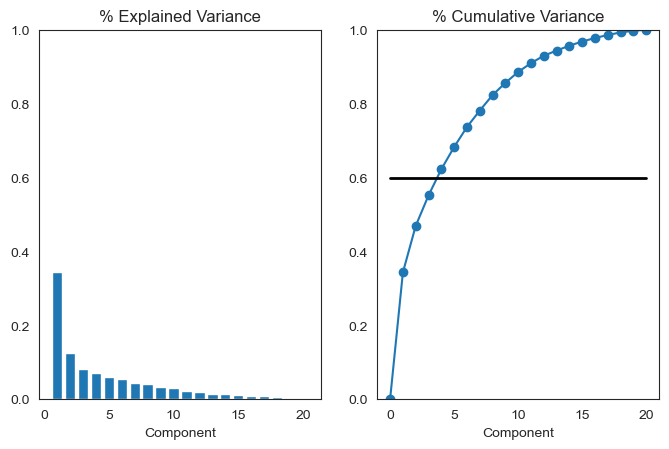

In [45]:
# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].plot([0, n], [0.6, 0.6], color='k', linestyle='-', linewidth=2)
#axs[1].plot([0, n], [0.9, 0.9], color='k', linestyle='-', linewidth=2)
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)
        
# Set up figure
fig.set(figwidth=8, dpi=100);

plt.savefig('Variance.png')

In [20]:
loadings = pd.DataFrame(
   pca.components_.T,                     # transpose the pca matrix 
   columns=component_names,               # so the columns are the principal components
   index=df_selected_features.columns,                      # and the rows are the original features
)
loadings      

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
MaxAbsEStateIndex,-0.559596,-0.373551,0.004564,-0.155885,-0.263879,-0.340382,0.251350,0.004518,0.227064,-0.153829,-0.150823,0.001322,-0.348591,0.146329,0.173864,0.017457,0.037508,0.001282,0.036483,-0.011411
MinAbsEStateIndex,0.267969,0.184408,-0.014297,0.008032,0.165795,0.101870,-0.086461,0.008436,0.049086,0.101998,0.046687,0.060802,-0.531068,0.366905,0.475289,0.411682,0.123989,-0.003981,-0.046183,-0.016121
qed,0.130717,-0.487436,-0.600605,0.093863,0.212443,-0.253969,0.006116,-0.228500,-0.327087,0.210727,0.042126,0.167019,0.034982,0.116653,-0.092931,0.090218,0.025317,-0.005751,-0.019818,0.012831
MolWt,-0.368033,0.298346,-0.103034,-0.090945,0.076464,-0.023266,-0.204637,-0.161835,0.054984,0.166745,-0.147420,0.175181,0.109753,0.038812,-0.179988,0.263419,0.004462,-0.171365,-0.039343,-0.672815
MaxPartialCharge,-0.233344,-0.171591,0.351877,0.180247,0.348942,-0.122723,-0.136209,-0.226605,-0.109727,-0.024969,-0.005313,-0.068537,0.409467,-0.153869,0.514801,0.176121,0.155004,0.027472,0.142749,0.056139
MinPartialCharge,0.100541,-0.053091,0.054639,-0.407975,0.295609,-0.149659,-0.035006,0.078017,0.176424,0.253738,-0.227427,-0.489502,0.216797,0.439961,-0.023342,-0.125999,-0.226088,-0.067334,-0.005528,0.032206
FpDensityMorgan1,-0.042043,-0.358171,0.120524,0.103671,-0.363804,0.101085,-0.587468,0.133805,-0.135154,0.045416,0.153573,-0.377104,-0.083866,-0.007210,-0.120658,0.268346,-0.061576,-0.201243,-0.121330,-0.017083
BCUT2D_CHGHI,-0.277249,-0.148800,-0.105444,-0.056205,0.348294,0.344696,-0.076525,0.330474,-0.002325,-0.186026,-0.058984,0.072336,0.053858,0.067808,-0.023657,-0.051649,0.202412,0.224541,-0.619685,0.045524
BCUT2D_CHGLO,0.251721,0.052169,0.304251,0.014221,-0.126652,-0.448224,-0.155759,-0.171196,-0.059966,-0.271452,0.053320,0.223511,0.098962,0.342641,-0.088137,-0.220161,0.299096,-0.169112,-0.368171,-0.059204
BCUT2D_LOGPHI,-0.109675,-0.042834,-0.112627,-0.028689,0.177726,0.205881,-0.110261,0.198779,0.068719,-0.313276,0.014622,0.285499,0.092735,0.213488,-0.036107,-0.016365,-0.025488,-0.655406,0.346655,0.237220


In [29]:
def plot_loadings(PC_1, PC_2):
    labels = loadings.index
    sns.set_style('white')
    sns.scatterplot(data=loadings, x=PC_1, y=PC_2, hue=labels, palette = 'Paired')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')
    plt.axline((-0.2, -0.2), slope = 1,color ='r', linestyle = 'dotted')

    plt.legend(ncol =5, title = 'Variables', loc='center left', bbox_to_anchor=(1.0, 0.5))

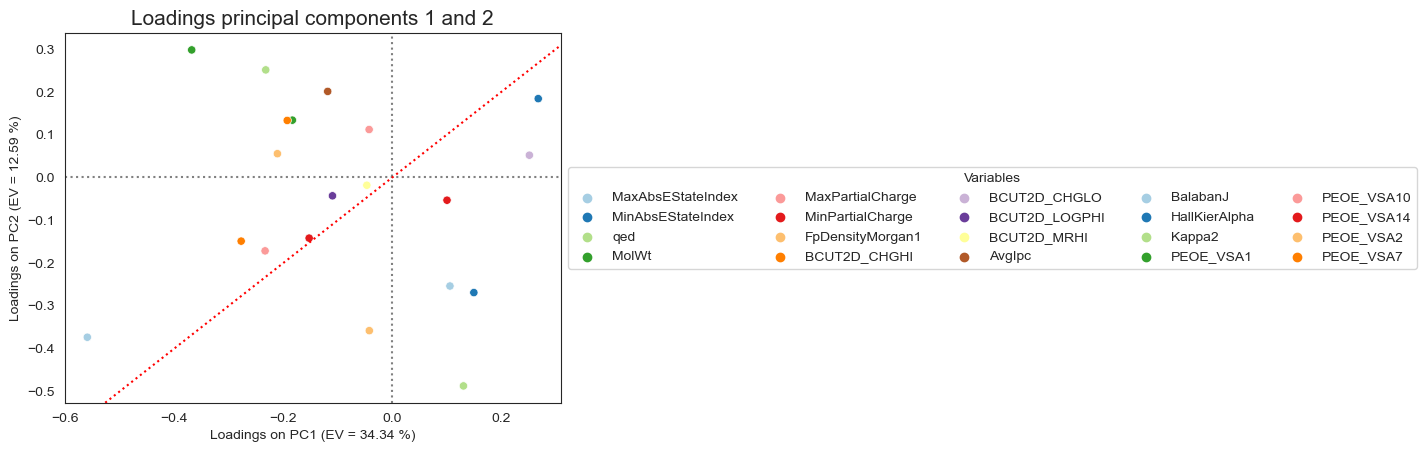

In [41]:
plot_loadings(PC_1 ='PC1', PC_2= 'PC2')               # IS ZO NIETS ZICHTBAAR< Worden te veel variabelen meegenomen. 

plt.xlabel('Loadings on PC1 (EV = 34.34 %)')
plt.ylabel('Loadings on PC2 (EV = 12.59 %)')
plt.title('Loadings principal components 1 and 2', fontsize = 15)

plt.savefig('loadings_plot.png')

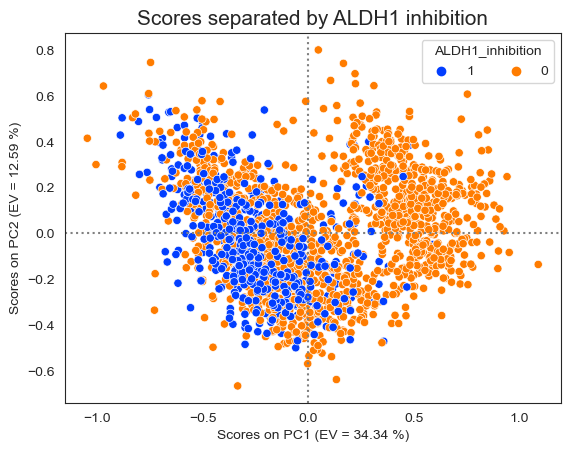

In [42]:
def plot_scores(label, PC_1, PC_2, X_train, Y_train):
    labels = Y_train.values
    sns.set_style('white')
    sns.scatterplot(x=df_pca[:, PC_1], y=df_pca[:, PC_2], hue=labels, palette='bright')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')

    plt.legend(loc='best', ncol=2, title=label)

# Call the function with the appropriate arguments
plot_scores(label='ALDH1_inhibition', PC_1=0, PC_2=1, X_train=X_train, Y_train=Y_train)

plt.xlabel('Scores on PC1 (EV = 34.34 %)')
plt.ylabel('Scores on PC2 (EV = 12.59 %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

plt.savefig('scores_1.png')

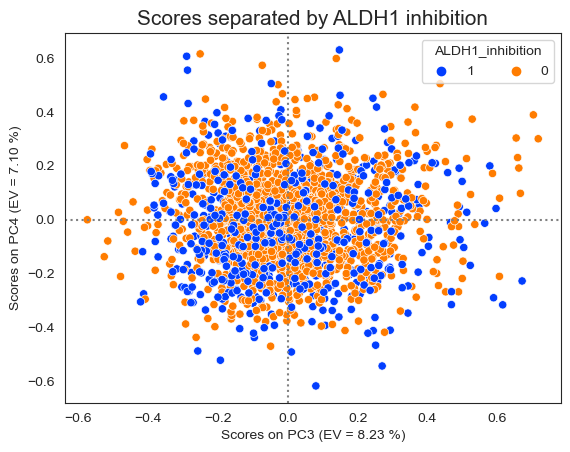

In [43]:
# Call the function with the appropriate arguments
plot_scores(label='ALDH1_inhibition', PC_1=2, PC_2=3, X_train=X_train, Y_train=Y_train)

plt.xlabel('Scores on PC3 (EV = 8.23 %)')
plt.ylabel('Scores on PC4 (EV = 7.10 %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)
plt.savefig('scores_2.png')